# C3M1: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Apply Binomial regression methods to real data.
2. Understand how to analyze and interpret binomial regression models.
3. Flex our math skills by determining whether certain distributions are members of the exponential family.

General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [39]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(caret)

## Problem 1: Binomial (Logistic) Regression

The National Institute of Diabetes and Digestive and Kidney Diseases conducted a study of 768 adult female Pima Indians living near Phoenix, AZ. The purpose of the study was to investigate the factors related to diabetes. 

*Before we analyze these data, we should note that some have raised ethical issues with its collection and popularity in the statistics and data science community. We should think seriously about these concerns. For example, Maya Iskandarani wrote a brief [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. After you familarize yourself with the data, we'll then turn to these ethical concerns.*


First, we'll use these data to get some practice with GLM and Logistic regression.

In [40]:
# Load the data
pima = read.csv("pima.txt", sep="\t")
# Here's a description of the data: https://rdrr.io/cran/faraway/man/pima.html
head(pima)

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


### 1. (a) Data Cleaning? What about Data Scrubbing? Data Sterilizing?

This is a real data set, which means that there's likely going to be gaps and missing values in the data. Before doing any modeling, we should inspect the data and clean it if necesary.

Perform simple graphical and numerical summaries of the data. Pay attention to missing or nonsensical values. Can you find any obvious irregularities? If so, take appropriate steps to correct these problems. In the markdown cell, specify what cleaning you did and why you did it.

Finally, split your data into training and test sets. Let the training set contain $80\%$ of the rows and the test set contain the remaining $20\%$.

In [41]:
# check for missing values
colSums(is.na(pima))

pregnant   glucose diastolic   triceps   insulin       bmi  diabetes       age 
        0         0         0         0         0         0         0         0 
     test 
        0

In [42]:
# check for nonsensical values
# pregnant - Number of times pregnant
# glucose - Plasma glucose concentration at two hours in an oral glucose tolerance test
# diastolic - Diastolic blood pressure (mm Hg)
# triceps - Triceps skin fold thickness (mm)
# insulin - 2-hour serum insulin (mu U/ml)
# bmi - kg/m^2
# diabetes - Diabetes pedigree function
# age - years
# test - whether or not the patient shows signs of diabetes (binary)
summary(pima)

    pregnant         glucose        diastolic         triceps     
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    insulin           bmi           diabetes           age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00  
      test      
 Min.   :0.000  
 1st Qu.:0.000  
 Median :0.000  
 

In [43]:
dim(pima)

[1] 768   9

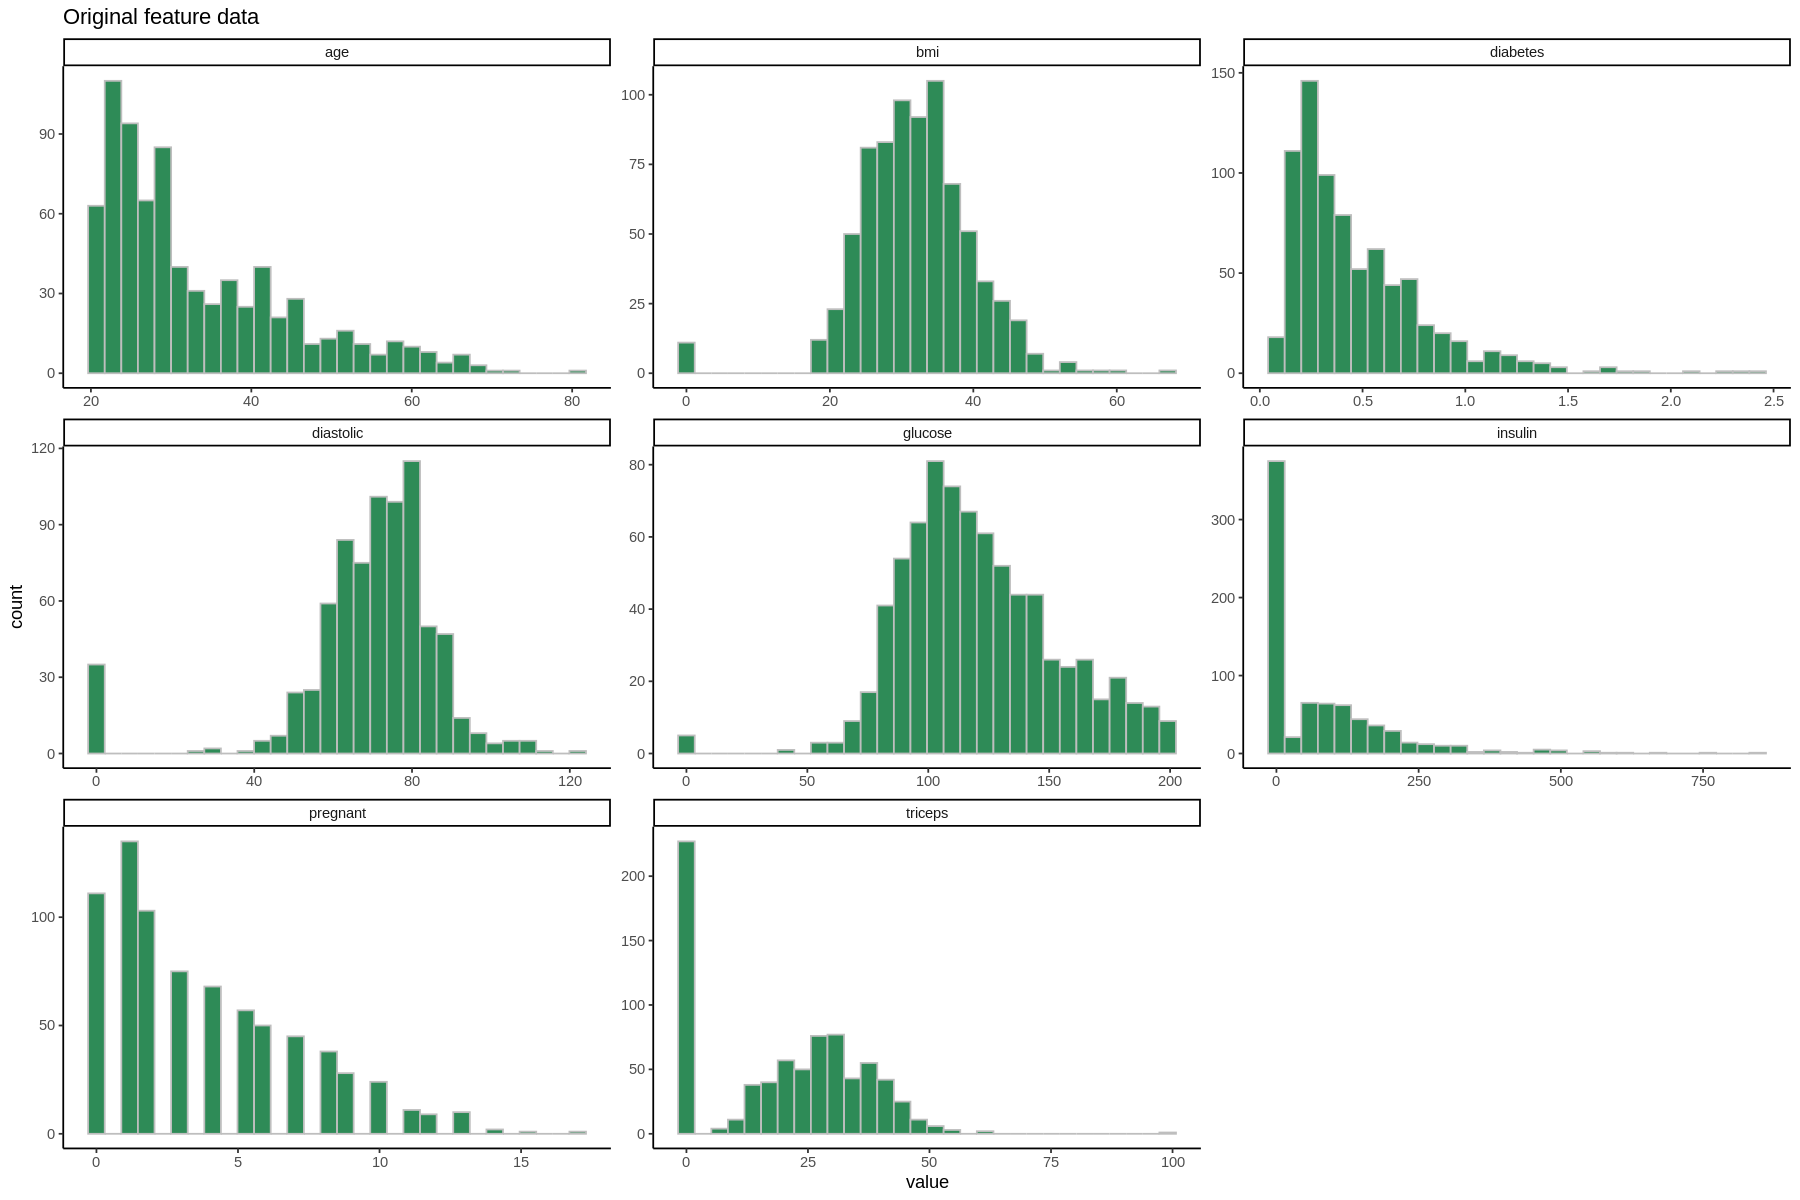

In [44]:
# combine everything into a long format
options(repr.plot.width = 15, repr.plot.height = 10)
# plot each of the features
pima %>% 
    pivot_longer(!test, names_to = "feature") %>% 
    ggplot(aes(value)) +
    geom_histogram(bins = 30, fill = "seagreen", colour = "grey") +
    facet_wrap(~feature, scales = "free") +
    labs(title = "Original feature data") +
    theme_classic()
options(repr.plot.width = NULL, repr.plot.height = NULL)

In [45]:
# bmi, diastolic, glucose, insulin and triceps all have zero values (which are impossible)
# replace with the median value where possible and otherwise just NA
pima <- pima %>% 
    mutate(across(c(bmi, diastolic, glucose), ~ifelse(.x == 0, median(.x), .x))) %>% 
    mutate(across(c(insulin, triceps), ~ifelse(.x == 0, NA, .x)))
# remove rows with missing values (374)
pima <- na.omit(pima)
dim(pima)

# calculate the z-scores for each feature
zscores <- as.data.frame(scale(pima))
# filter for only the z-scores greater than 3
outliers <- zscores %>% filter(rowSums(abs(.) > 3) > 0)
row_idx <- rownames(outliers)
# create a new version of the data with the 28 outliers removed
pima2 <- pima %>% filter(!(rownames(.) %in% row_idx))
length(row_idx)

[1] 394   9

[1] 28

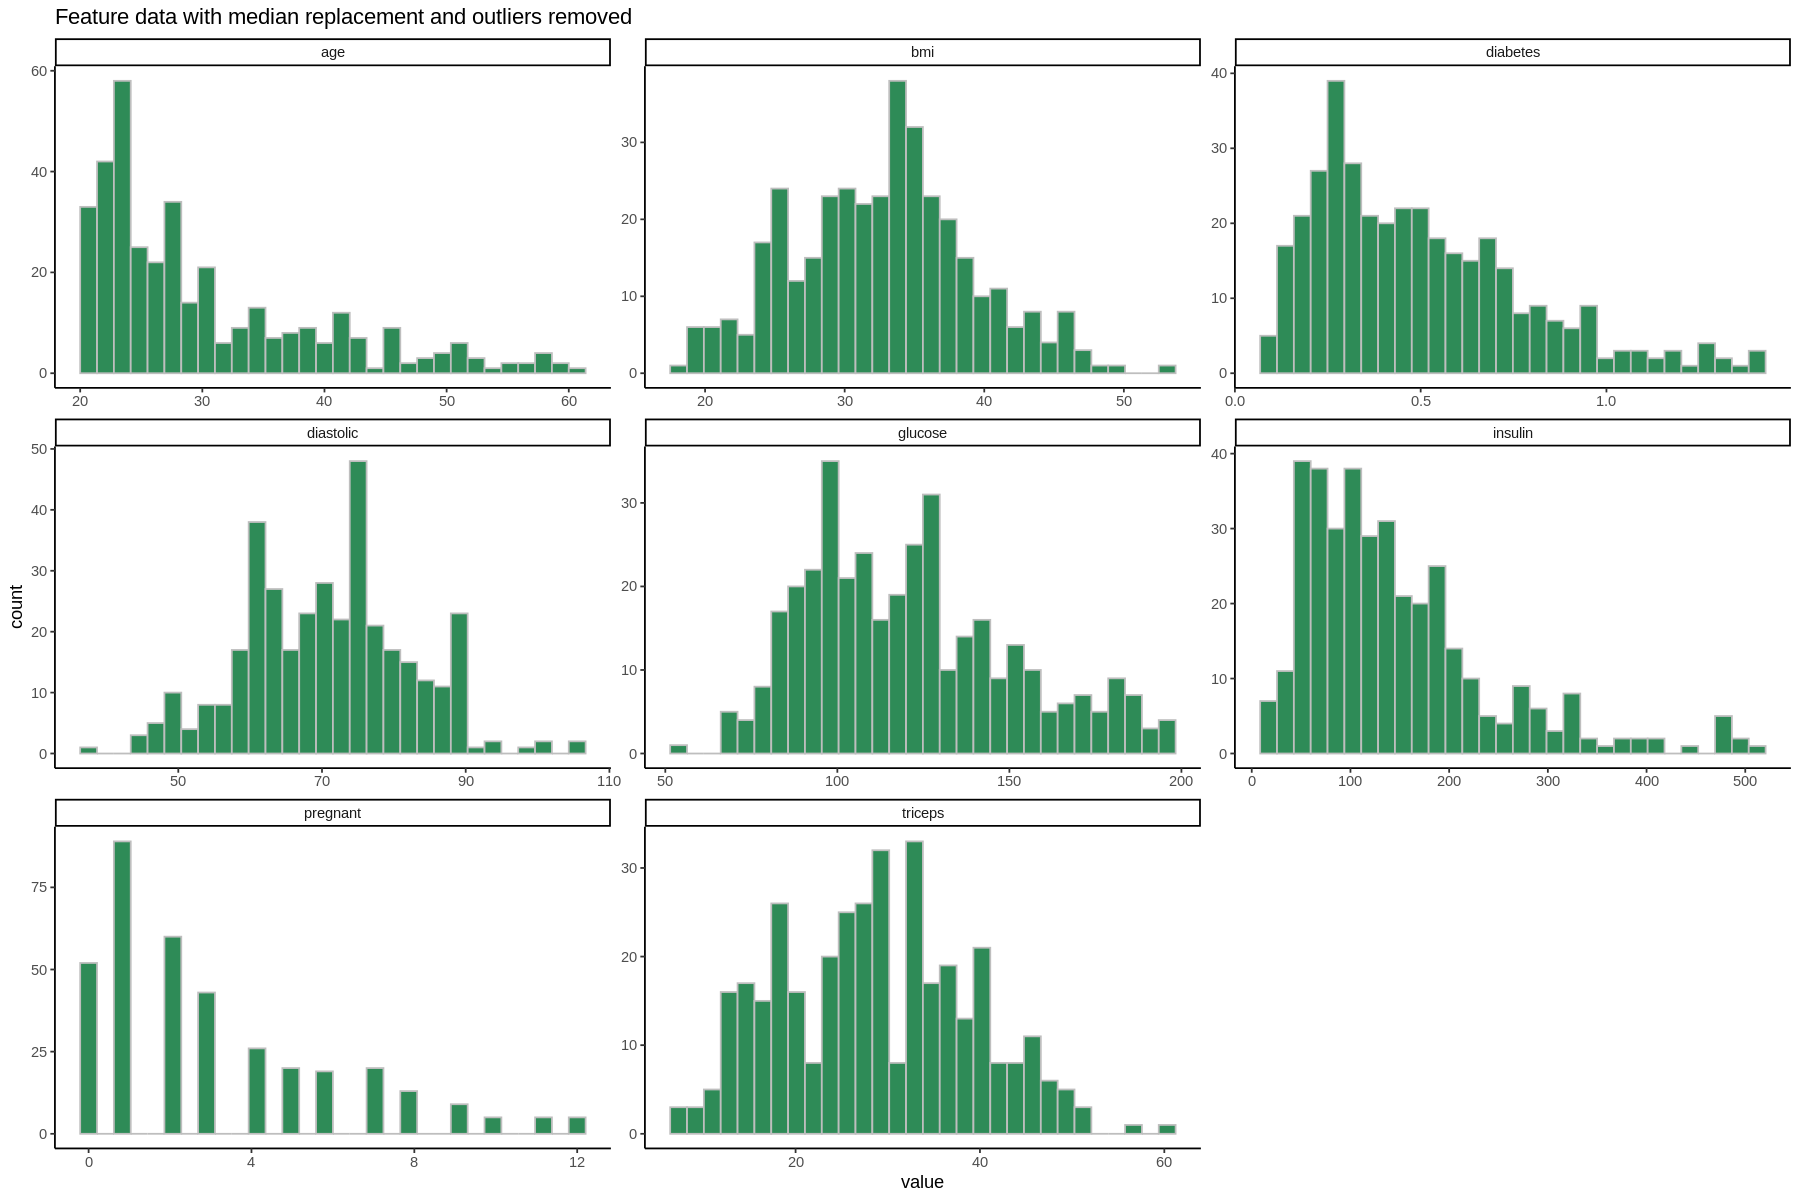

In [46]:
# combine everything into a long format
options(repr.plot.width = 15, repr.plot.height = 10)
# plot each of the features
pima2 %>% 
    pivot_longer(!test, names_to = "feature") %>% 
    ggplot(aes(value)) +
    geom_histogram(bins = 30, fill = "seagreen", colour = "grey") +
    facet_wrap(~feature, scales = "free") +
    labs(title = "Feature data with median replacement and outliers removed") +
    theme_classic()
options(repr.plot.width = NULL, repr.plot.height = NULL)

**What data cleaning did you perform and why?**

The purpose of data cleaning is to improve data quality and hence improve model performance in being able to accurately identify what distinguishes diabetic from non-diabetic individuals. Unlike some types of machine learning models, like tree-based models, logistic regression etc are affected by extreme values/outliers, which means that these need to be removed or otherwise handled to ensure model outputs are accurate.

There were zero-values in bmi, diastolic, glucose, insulin and triceps that looked like they were actually indicating a missing
value. These were replaced by the median value for that particular feature where possible. For insulin and triceps, the median value replacement created an odd peak in the histograms, so they were just replaced with NA and those rows removed (374 rows).

It was also observed that some of the features had extreme values. Z-scores were computed for every feature and an outlier defined as an absolute value of a z-score greater than 3. This removed and additional 28 rows from the dataset.

In [47]:
# split your data into training and test sets
# set a random seed for reproducibility
set.seed(2023)

split_idx <- createDataPartition(pima2$test, p = 0.8, list=FALSE)
train_data <- pima2[split_idx, ]
test_data <- pima2[-split_idx, ]

nrow(train_data)
nrow(test_data)

[1] 293

[1] 73

### 1. (b) Initial GLM modelling


Our data is clean and we're ready to fit! What kind of model should we use to fit these data? Notice that the `test` variable is either $0$ or $1$, for whether the individual tested positive for diabetes. Because `test` is binary, we should use logistic regression (which is a kind of binomial regression).

Fit a model with `test` as the response and all the other variables as predictors. Can you tell whether this model fits the data?


Call:
glm(formula = test ~ ., family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7722  -0.6253  -0.3301   0.5503   2.8085  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.196e+01  1.647e+00  -7.261 3.83e-13 ***
pregnant     9.860e-02  7.358e-02   1.340 0.180226    
glucose      4.147e-02  7.083e-03   5.856 4.75e-09 ***
diastolic    9.353e-03  1.523e-02   0.614 0.539128    
triceps      2.710e-02  2.114e-02   1.282 0.199781    
insulin      3.767e-04  1.875e-03   0.201 0.840780    
bmi          5.930e-02  3.615e-02   1.640 0.100936    
diabetes     2.068e+00  5.995e-01   3.450 0.000562 ***
age          3.029e-02  2.462e-02   1.230 0.218681    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 364.64  on 292  degrees of freedom
Residual deviance: 239.26  on 284  degrees of freedom
AIC: 257.26

Num

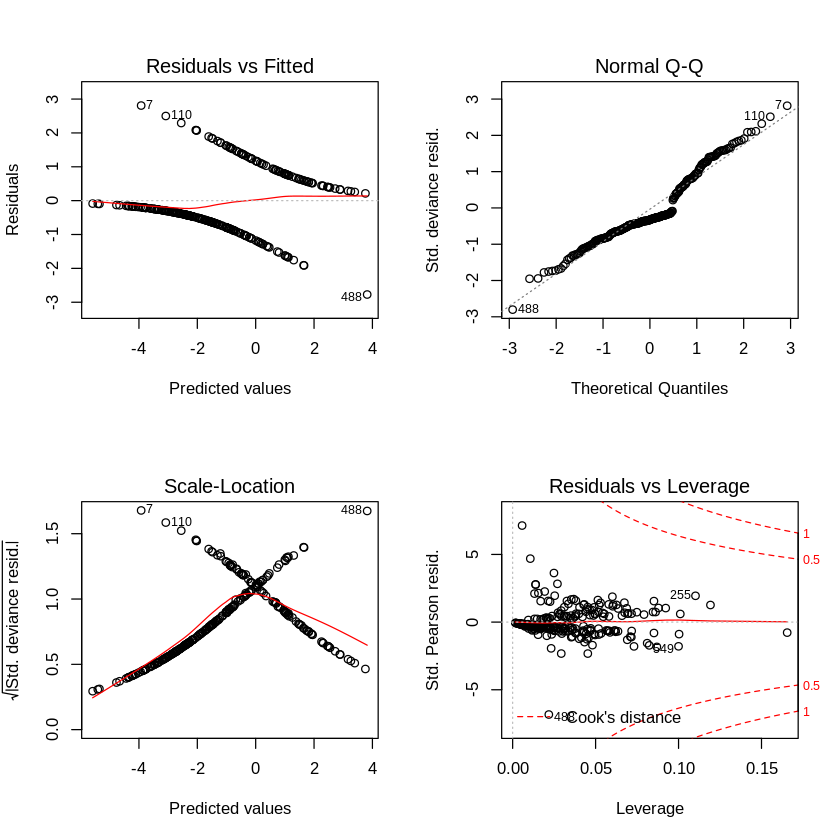

In [49]:
model <- glm(test ~., data = train_data, family = "binomial")
summary(model)

par(mfrow = c(2,2))
plot(model)

In [50]:
# calculate the p-value for the null hypothesis that the model fits the data well enough
pchisq(deviance(model), df.residual(model), lower = FALSE)

[1] 0.9748745

**Does the model fit the data?**

The p-value is large, so we do not have sufficient evidence to reject the null hypothesis that the estimated regression model fits the data well enough.

### 1. (c) Remember Bayes

A quick analytical interlude.

Is diastolic blood pressure significant in the regression model? Do women who test positive have higher diastolic blood pressures? Explain the distinction between the two questions and discuss why the answers are only apparently contradictory.

In [51]:
summary(model)$coefficients[,4][4]

diastolic 
0.5391276

In [52]:
train_data %>% group_by(test) %>% summarise(n = n(), mean_diastolic = mean(diastolic))

test,n,mean_diastolic
<int>,<int>,<dbl>
0,201,69.61194
1,92,74.97826


The two questions are similar but not the same. The first one is about the result of a diabetes test conditional on the value of the diastolic blood pressure feature. The second one is about the value of the diastolic blood pressure feature conditional on the results of a diabetes test. In Bayes' theorem, these are not the same question.

Furthermore, the first question is looking at the relationship between the feature and the target variable in the context of all the other features in the model that may or may not be helping to explain the target variable whereas the second question is considering that relationship in isolation.

As a result, the answers to each of the questions are only apparently contradictory. That is, the model says that diastolic blood pressure provides no additional information about the outcome of a diabetes test, but women that test positive for diabetes do actually have higher diastolic blood pressure on average.

### 1. (d) GLM Interpretation

We've seen so many regression summaries up to this point, how is this one different from all the others? Well, to really understand any model, it can be helpful to loop back and plug the fitted results back into the model's mathematical form.

Explicity write out the equation for the binomial regression model that you fit in (b). Then, in words, explain how a $1$ unit change of `glucose` affects `test`, assuming all other predictors are held constant.

In [53]:
summary(model)


Call:
glm(formula = test ~ ., family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7722  -0.6253  -0.3301   0.5503   2.8085  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.196e+01  1.647e+00  -7.261 3.83e-13 ***
pregnant     9.860e-02  7.358e-02   1.340 0.180226    
glucose      4.147e-02  7.083e-03   5.856 4.75e-09 ***
diastolic    9.353e-03  1.523e-02   0.614 0.539128    
triceps      2.710e-02  2.114e-02   1.282 0.199781    
insulin      3.767e-04  1.875e-03   0.201 0.840780    
bmi          5.930e-02  3.615e-02   1.640 0.100936    
diabetes     2.068e+00  5.995e-01   3.450 0.000562 ***
age          3.029e-02  2.462e-02   1.230 0.218681    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 364.64  on 292  degrees of freedom
Residual deviance: 239.26  on 284  degrees of freedom
AIC: 257.26

Num

$\hat{\eta}_i = \hat\beta_0 + \hat\beta_1pregnant + \hat\beta_2glucose + \hat\beta_3diastolic + \hat\beta_4triceps + \hat\beta_5insulin + \hat\beta_6bmi + \hat\beta_7diabetes + \hat\beta_8age = log(\frac{\hat{p}_i}{1-\hat{p}_i})$

$\hat{\eta}_i = -11.96 + 0.10pregnant + 0.04glucose - 0.01diastolic + 0.03triceps + 0.0004insulin + 0.06bmi + 2.07diabetes + 0.03age$

Assuming all other predictors are held constant, if glucose increases by 1 unit then the log-odds of testing positive for diabetes increasing by 0.04147. This means that the odds of testing positive for diabetes increases by $e^{\beta_j}$, which is approximately 1.04.

### 1. (e) GLM Prediction

One of the downsides of Logistic Regression is that there isn't an easy way of evaulating the goodness of fit of the model without predicting on new data. But, if we have more data to test with, then there are many methods of evaluation to use. One of the best tools are confusion matrices, which (despite the name) are actually not that hard to understand.

A confusion matrix compares the predicted outcomes of a Logistic Regression Model (or any classification model) with the actual classifications. For binary classification, it is a $2 \times 2$ matrix where the rows are the models' predicted outcome and the columns are the actual classifications. An example is displayed below.

|  | True | False |  
| --- | --- | --- |
| 1 | 103 | 37 |  
| 0 | 55  | 64 |  

In the example, we know the following information:
* The [1,1] cell is the number of datapoints that were correctly predicted to be $1$. The value (103) is the number of True Positives (TP). 
* The [2,2] cell is the number of datapoints that were correctly predicted to be $0$. The value is the number of True Negatives (TN).
* The [1, 2] cell is the number of datapoints that were predicted to be $1$ but where actually $0$. This is the number of False Positives (FP), also called Type I error. In the context of our diabetes dataset, this would mean our model predicted that the person would have diabetes, but they actually did not.
* The [2, 1] cell is the number of datapoints that were predicted to be $0$ but where actually $1$. This is the number of False Negatives (FN), also called Type 2 error. In the context of our diabetes dataset, this would mean our model predicted that the person would not have diabetes, but they actually did have diabetes.

Use your model to predict the outcomes of the test set. Then construct a confusion matrix for these predictions and display the results.

In [54]:
# make predictions
predicted_probs <- predict(model, newdata = test_data, type = "response")
predicted_class <- ifelse(predicted_probs > 0.5, 1, 0)

# construct a confusion matrix
predicted_class <- factor(predicted_class, levels = c(0,1))
true_labels <- factor(test_data$test, levels = c(0, 1))

confusion_matrix <- table(Predicted = predicted_class, Actual = true_labels)
confusion_matrix

         Actual
Predicted  0  1
        0 46 11
        1  4 12

- 12 positive datapoints were correctly predicted and 46 negative datapoints were correctly predicted.
- 11 positive datapoints were incorrectly predicted as the negative class (incorrectly predicted as not having diabetes).
- 4 negative datapoints were incorrectly predicted as the positive class (incorrectly predicted as having diabetes).

### 1. (f) Evaluation Statistics

Using the four values from the confusion matrix, we can construct evaulation statistics to get a numerical approximation for our model's performance. Spend some time researching accuracy, precision, recall and F score. 

Calculate these values for your model's predictions on the test set. Clearly display your results. How well do you think your model fits the data?

In [55]:
tp <- sum(predicted_class == 1 & true_labels == 1)
tn <- sum(predicted_class == 0 & true_labels == 0)
fp <- sum(predicted_class == 1 & true_labels == 0)
fn <- sum(predicted_class == 0 & true_labels == 1)

accuracy <- (tp + tn) / length(true_labels)
precision <- tp / (tp + fp)
recall <- tp / (tp + fn)
f1_score <- 2 * (precision * recall) / (precision + recall)

cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")
cat("F1 Score:", f1_score, "\n")

Accuracy: 0.7945205 
Precision: 0.75 
Recall: 0.5217391 
F1 Score: 0.6153846 


- Accuracy is high, indicating that the model is making correct predictions for the majority of the dataset.
- Precision is a measure of a model's ability to avoid false positives. When it predicts the positive class, it's correct 75% of the time.
- Recall is a measure of a model's ability to avoid false negatives. It only gets about 52.2% of the actual positive class correct.
- F1 score is the harmonic mean of precision and recall and provides a balanced measure of a model's overall performance. In this case, the F1 score is 0.62, which is being dragged down by the model's low recall.

The model doesn't fit the data horribly, but I'd like to see a higher recall and F1 score (without too much drop in precision), before being entirely happy.

### 1. (g) Understanding Evaluation Statistics

Answer the following questions in the markdown cell below.

1. Give an example scenario for when accuracy would be a misleading evaulation statistic.
2. Confusion matrices can also be used for non-binary classification problems. Describe what a confusion matrix would look like for a response with $3$ levels.
3. You'll have to take our word on the fact (or spend some time researching) that Type I error and Type II error are inversely related. That is, if a model is very good at detecting false positives, then it will be bad at detecting false negatives. In the case of our diabetes dataset, would you prefer a model that overestimates the Type 1 error or overestimates the Type II error. Justify your answer.

1. Accuracy is typically misleading as an indicator of model quality when the sizes of the outcome classes differ. If they're not the same and one is much larger than the other(s), then the baseline accuracy is no longer 0.5 or 50%. This is because a model will have very high accuracy just by assigning every observation to the biggest outcome class. For example, in this dataset, the accuracy is 67.4% just by doing exactly that.
2. A confusion matrix with 3 classes would be a 3 by 3 matrix instead of a 2 by 2 matrix. All the standard evaluation metrics still apply, but it becomes a one-vs-the-rest type of calculation.
3. For this dataset, I would prefer that there are more false positives than false negatives predicted. It would maximise the chance of correctly identifying all the individuals with diabetes at the expense of incorrectly diagnosing some of the healthy individuals rather than making the opposite mistake of misdiagnosing some of the diabetic individuals as healthy. The latter would be the more problematic mistake. In other words, I would prefer a model that makes more Type 1 errors over one that makes more Type II errors.

### 1. (h) Ethical Issues in Data Collection

Read Maya Iskandarani's [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. Summarize those concerns here.

Maya's article was about the privacy and consent of individuals involved in research in the era of big data. The study that generated the pima dataset was meant to only last 10 years, but ended up lasting 40 years. Then the information was stored in the UCI Machine Learning repository, which is now an open-access website that is regularly used for machine learning and other statistical modelling purposes. The problem is that the information in datasets like this one is actual data from real people and could be considered a violation of personal privacy. However, at the same time, the researchers might never have imagined or intended for the data to be stored and made available on an open-access website, and therefore could never have realistically added that to the consent requested by the study participants. Finally, Maya hints that this is an ongoing issue that is yet to be resolved. 

## Problem 2: Practicing those Math skills

One of the conditions of GLMs is that the "random component" of the data needs to come from the Exponential Family of Distributions. But how do we know if a distribution is in the Exponential Family? Well, we could look it up. Or we could be proper mathematicians and check the answer ourselves! Let's flex those math muscles.

### 2. (a) But it's in the name...

Show that $Y \sim exponential(\lambda)$, where $\lambda$ is known, is a member of the exponential family.

Y is a random variable from the exponential family if the probability density function (pdf) or probability mass function (pmf) can be written as:
$f(y;\theta,\phi) = exp {\frac{y\theta-b(\theta)}{a(\phi)}+c(y,\phi)}$

Y is exponentially distributed if the pdf of Y is:
$f(y; \lambda) = \lambda{e}^{-\lambda{y}}
               = exp(log(\lambda{e}^{-\lambda{y}})
               = exp(log(\lambda)-\lambda{y})
               = exp(\frac{\lambda{y}-log(\lambda)}{-1}+0)$,

which is in the form of the exponential family of distributions.

Therefore, $Y \sim exponential(\lambda)$, where $\lambda$ is known, is a member of the exponential family.

### 2. (b) Why can't plants do math? Because it gives them square roots!

Let $Y_i \sim exponential(\lambda)$ where $i \in \{ 1, \dots, n\}$. Then $Z = \sum_{i=1}^n Y_i \sim Gamma(n, \lambda)$. Show that $Z$ is also a member of the exponential family.

Y is exponentially distributed if the pdf of Y is: $f(y;n,\lambda) = \frac{\lambda^n}{\Gamma(n)}y^{n-1}e^{-\lambda{y}}$, which is in the form of the exponential family of distributions.

Therefore, $Z$ is also a member of the exponential family.